In [1]:
import os
from pathlib import Path
import torch, gc
import wandb
from torch import nn, optim

from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset

import torchvision
from torchvision import datasets
from torchvision import models
from torchvision.transforms import transforms
from torchinfo import summary

from datetime import datetime

import sys

import random
torch.manual_seed(42)
random.seed(42) # 시드 고정

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl

sys.path.append(str(BASE_PATH))

# BASE_PATH 에 들어있는 폴더 전개
print(BASE_PATH)
print("BASE_PATH contents:")
for name in os.listdir(BASE_PATH):
    print(" -", name)

from _04_your_code.utils import get_num_cpu_cores, is_linux, is_windows

from _04_your_code.trainer import ClassificationTrainer

c:\Users\user\git\link_dl
BASE_PATH contents:
 - .DS_Store
 - .git
 - .gitignore
 - checkpoints
 - HW3_checkpoints
 - LICENSE
 - python_path.py
 - README.md
 - temp
 - wandb
 - _00_data
 - _01_code
 - _02_advanced_code
 - _03_homeworks
 - _04_your_code


# [문제 1] Fashion MNIST 데이터 정규화를 위한 Mean과 Std.값 찾기

In [2]:
def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Data Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])
    print("Sample Data Target: ", f_mnist_train[0][1])  # 9

    num_data_loading_workers = get_num_cpu_cores()
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    mean = 0.0   # 전체 평균
    M2 = 0.0     # 분산 * 개수
    count = 0    # 전체 픽셀 수

    for sample in f_mnist_train:
        x = sample[0]          # [1, 28, 28]
        x = x.view(-1)         # [784]
        n = x.numel()          # 이 샘플 픽셀 수

        # 샘플(한 장) 기준 평균/분산
        sample_mean = x.mean()
        # 여기서 population 분산으로 하는 게 맞음
        sample_var  = x.var(unbiased=False)

        # --- merge ---
        delta = sample_mean - mean
        old_count = count
        count = old_count + n

        # 새 전체 평균
        mean = mean + delta * (n / count)

        # 새 M2
        M2 = M2 + sample_var * n + (delta * delta) * (old_count * n / count)

    # 최종 분산/표준편차
    var = M2 / count
    std = var.sqrt()

    print("mean:", mean)
    print("std :", std)

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=mean, std=std), # 1번 문제. 정확한 mean 값과 std 값을 찾으시오.
    )

    return train_data_loader, validation_data_loader, f_mnist_transforms

In [3]:
def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    mean = 0.0   # 전체 평균
    M2 = 0.0     # 분산 * 개수
    count = 0    # 전체 픽셀 수

    for sample in f_mnist_test:
        x = sample[0]          # [1, 28, 28]
        x = x.view(-1)         # [784]
        n = x.numel()          # 이 샘플 픽셀 수

        # 샘플(한 장) 기준 평균/분산
        sample_mean = x.mean()
        # 여기서 population 분산으로 하는 게 맞음
        sample_var  = x.var(unbiased=False)

        # --- merge ---
        delta = sample_mean - mean
        old_count = count
        count = old_count + n

        # 새 전체 평균
        mean = mean + delta * (n / count)

        # 새 M2
        M2 = M2 + sample_var * n + (delta * delta) * (old_count * n / count)

    # 최종 분산/표준편차
    var = M2 / count
    std = var.sqrt()

    print("mean:", mean)
    print("std :", std)

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=mean, std=std), # 1번 문제. 정확한 mean 값과 std 값을 찾으시오.
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

In [4]:
if __name__ == "__main__":
    config = {'batch_size': 2048, }
    wandb.init(mode="disabled", config=config)

    train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
    print()
    f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()

Num Train Samples:  55000
Num Validation Samples:  5000
Sample Data Shape:  torch.Size([1, 28, 28])
Sample Data Target:  9
Number of Data Loading Workers: 12
mean: tensor(0.2856)
std : tensor(0.3527)

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
mean: tensor(0.2868)
std : tensor(0.3524)


# [문제 2]	Fashion	MNIST	데이터에	대하여	CNN	학습시키기

만족해야 할 요구사항<br>
• Validation	Accuracy:	94.0% 이상<br>
• Validation	Accuracy:	91.0%	이상	~	94.0%	미만:	10만점에서	8점	이상	획득	불가 <br>
• Validation	Accuracy:	91.0%	미만:	10만점에서	7점	이상	획득	불가<br>

학습 데이터, 검증 데이터, 테스트 데이터를 가져오는 코드는 반드시 다음 
코드를 Colab으로 가져와 활용하기

위	f_mnist_transforms 객체에	추가적인	transform	객체를	넣어	활용하는	것	허용
예를	들어	Image	Augmentation	기법 활용	가능

이미지 증강을 위해 서로 다른 증강 기법을 적용하여 훈련 데이터를 4배로 증강시켰다.
공통 평균과 표준편차는 문제 1에서 구한 값을 적용하였다.

In [5]:
def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    train_indices = list(range(0, 55_000))
    val_indices   = list(range(55_000, 60_000))

    # 공통 normalize
    mean_, std_ = 0.2856, 0.3527

    clean_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean_, std_),
    ])

    # 서로 살짝씩 다른 증강 3종
    aug_tf1 = transforms.Compose([
        transforms.RandomCrop(28, padding=2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_, std_),
    ])
    aug_tf2 = transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean_, std_),
    ])
    aug_tf3 = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean_, std_),
    ])

    # 한 번만 다운로드
    base_clean = datasets.FashionMNIST(
        data_path, train=True, download=True, transform=clean_tf
    )
    # 나머지는 같은 파일을 쓰니까 download=False
    base_aug1 = datasets.FashionMNIST(
        data_path, train=True, download=False, transform=aug_tf1
    )
    base_aug2 = datasets.FashionMNIST(
        data_path, train=True, download=False, transform=aug_tf2
    )
    base_aug3 = datasets.FashionMNIST(
        data_path, train=True, download=False, transform=aug_tf3
    )

    # 인덱스 잘라서 55k만
    train_clean = Subset(base_clean, train_indices)
    train_aug1  = Subset(base_aug1,  train_indices)
    train_aug2  = Subset(base_aug2,  train_indices)
    train_aug3  = Subset(base_aug3,  train_indices)

    # 검증은 원본 깨끗한 거만
    f_mnist_validation = Subset(base_clean, val_indices)

    # 55k * 4 = 220k
    f_mnist_train = ConcatDataset([train_clean, train_aug1, train_aug2, train_aug3])

    print("Num Train Samples: ", len(f_mnist_train))          # 220000 나올 것
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Data Shape: ", f_mnist_train[0][0].shape)
    print("Sample Data Target: ", f_mnist_train[0][1])

    num_data_loading_workers = get_num_cpu_cores()  # 필요하면 늘려
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train,
        batch_size=wandb.config.batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=num_data_loading_workers,
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation,
        batch_size=wandb.config.batch_size,
        pin_memory=True,
        num_workers=num_data_loading_workers,
    )

    f_mnist_transforms = None
    return train_data_loader, validation_data_loader, f_mnist_transforms

In [6]:
def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    common_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2856, std=0.3527),
    ])

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=common_tf)

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    num_data_loading_workers = get_num_cpu_cores()

    test_data_loader = DataLoader(dataset=f_mnist_test, 
                                  batch_size=wandb.config.batch_size, 
                                  pin_memory=True, 
                                  num_workers=num_data_loading_workers
                                  )

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2868, std=0.3524),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

In [7]:
def get_cnn_model1(config):
    in_channels = getattr(config, "in_channels", 1)
    num_classes = getattr(config, "n_output", 10)
    dropout_p   = getattr(config, "dropout", 0.3)  # 원하면 config에서 바꾸면 됨

    # ---- ResNet 기본 블록 ----
    class BasicBlock(nn.Module):
        expansion = 1
        def __init__(self, in_planes, planes, stride=1, downsample=None):
            super().__init__()
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                                   stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.relu = nn.ReLU(inplace=True)
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                                   stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(planes)
            self.downsample = downsample

        def forward(self, x):
            identity = x

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.conv2(out)
            out = self.bn2(out)

            if self.downsample is not None:
                identity = self.downsample(x)

            out = out + identity
            out = self.relu(out)
            return out

    # ---- 28x28용으로 살짝 줄인 ResNet ----
    class SmallResNet(nn.Module):
        def __init__(self, in_channels, num_classes, dropout):
            super().__init__()
            base_channels = 32   # 처음 채널 수

            # 28x28 입력용 첫 Conv (ImageNet용 7x7 말고 3x3로)
            self.inplanes = base_channels
            self.conv1 = nn.Conv2d(in_channels, base_channels, kernel_size=3,
                                   stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(base_channels)
            self.relu = nn.ReLU(inplace=True)

            # 레이어 구성: 28x28 -> 28x28 -> 14x14 -> 7x7
            self.layer1 = self._make_layer(BasicBlock, base_channels, blocks=2, stride=1)
            self.layer2 = self._make_layer(BasicBlock, base_channels*2, blocks=2, stride=2)
            self.layer3 = self._make_layer(BasicBlock, base_channels*4, blocks=2, stride=2)

            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.dropout = nn.Dropout(p=dropout) if dropout > 0 else nn.Identity()
            self.fc = nn.Linear(base_channels*4*BasicBlock.expansion, num_classes)

        def _make_layer(self, block, planes, blocks, stride):
            downsample = None
            if stride != 1 or self.inplanes != planes * block.expansion:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes * block.expansion,
                              kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes * block.expansion),
                )

            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes * block.expansion
            for _ in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)

            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.dropout(x)
            x = self.fc(x)
            return x

    return SmallResNet(in_channels, num_classes, dropout_p)

In [8]:
def get_cnn_model2(config):
    in_channels = getattr(config, "in_channels", 1)
    num_classes = getattr(config, "n_output", 10)
    dropout_p   = getattr(config, "dropout", 0.3)  # 원하면 config에서 바꾸면 됨

    class CNN3_128(nn.Module):
        """
        Fashion-MNIST (1x28x28)용 3-layer CNN
        대략 구조:
          Conv(1->32) -> BN -> ReLU
          Conv(32->64) -> BN -> ReLU -> MaxPool(2)   # 28 -> 14
          Conv(64->128) -> BN -> ReLU -> MaxPool(2)  # 14 -> 7
          Flatten
          FC(128*7*7 -> 256) -> ReLU -> Dropout
          FC(256 -> 10)
        """
        def __init__(self, in_ch, n_cls, dropout):
            super().__init__()
            self.features = nn.Sequential(
                # 1) 28x28 유지
                nn.Conv2d(in_ch, 32, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),

                # 2) 28x28 -> 28x28 -> MaxPool로 14x14
                nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),  # 28 -> 14

                # 3) 14x14 -> 14x14 -> MaxPool로 7x7
                nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),  # 14 -> 7
            )

            # 128채널, 7x7
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(128 * 7 * 7, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout) if dropout > 0 else nn.Identity(),
                nn.Linear(256, n_cls),
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    return CNN3_128(in_channels, num_classes, dropout_p)

In [9]:
def get_cnn_model3(config):
    in_channels = getattr(config, "in_channels", 1)
    num_classes = getattr(config, "n_output", 10)
    # 1) ResNet50 생성 (pretrained 안 쓰면 weights=None)
    model = models.resnet50(num_classes = num_classes, weights=None)

    # 2) 첫 conv를 1채널용으로 교체 (원래 in_channels=3)
    model.conv1 = nn.Conv2d(
        in_channels=in_channels,     # ★ 여기!
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
        bias=False,
    )

    # 3) 마지막 FC를 과제 라벨 수에 맞게 수정
    model.fc = nn.Linear(model.fc.in_features, config.n_output)

    return model

In [10]:
def get_resnet_model(num_classes=10):
  class ResnetBlock(nn.Module):

    def __init__(self, out_channels, stride=1, downsample=None):
      """
      in_channels는 LazyConv2d가 자동으로 추론함!
      """
      super(ResnetBlock, self).__init__()

      self.conv1 = nn.LazyConv2d(
        out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
      self.bn1 = nn.LazyBatchNorm2d()

      self.relu = nn.ReLU(inplace=True)
      self.downsample = downsample

    def forward(self, x):
      identity = x

      out = self.conv1(x)
      out = self.bn1(out)

      if self.downsample is not None:
        identity = self.downsample(x)

      out += identity
      out = self.relu(out)

      return out

  # ------------------------------------
  # ResNet-18 using Lazy Modules
  # ------------------------------------
  class ResNet18(nn.Module):
    def __init__(self):
      super(ResNet18, self).__init__()

      # 처음 stem 부분 → LazyConv 사용
      self.conv1 = nn.LazyConv2d(
        out_channels=64, kernel_size=7, stride=1, padding=3, bias=False
        )
      self.bn1 = nn.LazyBatchNorm2d()
      self.relu = nn.ReLU(inplace=True)
      self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

      # stem 출력 채널
      self.in_channels = 64

      # ResNet stages (10 blocks × 4 layers)
      self.layer1 = self._make_layer(out_channels=128, blocks=3, stride=1)
      self.layer2 = self._make_layer(out_channels=256, blocks=3, stride=2)
      self.layer3 = self._make_layer(out_channels=512, blocks=3, stride=2)
      self.layer4 = self._make_layer(out_channels=1024, blocks=3, stride=2)

      self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
      self.fc = nn.LazyLinear(num_classes)

    def _make_layer(self, out_channels, blocks, stride):
      downsample = None

      # downsample 로직 → LazyConv/BatchNorm 활용
      if stride != 1 or self.in_channels != out_channels:
        downsample = nn.Sequential(
          nn.LazyConv2d(out_channels, kernel_size=1, stride=stride, bias=False),
          nn.LazyBatchNorm2d()
        )

      layers = []
      layers.append(ResnetBlock(out_channels, stride=stride, downsample=downsample))

      # 다음 레이어용 채널 업데이트
      self.in_channels = out_channels

      for _ in range(1, blocks):
        layers.append(ResnetBlock(out_channels))

      return nn.Sequential(*layers)

    def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)

      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      x = self.avgpool(x)
      x = torch.flatten(x, 1)
      x = self.fc(x)
      return x

  my_model = ResNet18()
  return my_model

 마크다운 글 작성 방법으로 본인이 찾은
최적의 하이퍼파라미터 정리하여 제시<br>
• Learning	Rate,	Batch	Size,	Early	Stop	Patience<br>
 • Weight	Decay	Value<br>
 • Normalization	Type<br>
 • Dropout	Rate 등<br>

epochs: 100<br>
batch_size: 256<br>
validation_intervals: 1<br>
learning_rate: 1e-4<br>
early_stop_patience: 20<br>
early_stop_delta: 0<br>
weight_decay: 1e-4<br>
dropout: 0.5<br>

In [11]:
CURRENT_FILE_PATH = os.path.dirname(get_base_dir())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "HW3_checkpoints")
os.makedirs(CHECKPOINT_FILE_PATH, exist_ok=True)

def main():
    config = {
        'epochs': 100,
        'batch_size': 256,
        'validation_intervals': 1,
        'learning_rate': 1e-4,
        'early_stop_patience': 20,
        'early_stop_delta': 0,
        'weight_decay': 1e-4,
        'dropout': 0.5,
        'in_channels': 1,
        'n_output': 10,
    }

    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    name = "{0}_{1}".format("HW3", run_time_str)
    project_name = "cnn_mnist_with_normalization"
    wandb.init(
        mode="online" if wandb else "disabled",
        project=project_name,
        notes="cifar10 experiment with cnn and normalization",
        tags=["cnn", "mnist", "normalization"],
        name=name,
        config=config
    )
    print(wandb.config)

    print(torch.cuda.is_available())

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    train_data_loader, validation_data_loader, mnist_transforms = get_fashion_mnist_data()
    mnist_test_images, test_data_loader, mnist_test_transforms = get_fashion_mnist_test_data()

    model = get_cnn_model2(config)#get_resnet_model(num_classes=10)
    model.to(device)

    optimizers = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizers,
        train_data_loader, validation_data_loader, mnist_transforms,
        test_data_loader, mnist_test_transforms,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    """
    latest_model = get_resnet_model(num_classes=10)
    latest_file_path = os.path.join(CHECKPOINT_FILE_PATH, "cnn_mnist_with_normalization_checkpoint_latest.pt")
    latest_model.load_state_dict(torch.load(latest_file_path, map_location=device))
    latest_model = latest_model.to(device)
    latest_model.eval() # 모델 평가 모드

    loss_fn = nn.CrossEntropyLoss()

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
        for validation_batch in validation_data_loader:
            input_validation, target_validation = validation_batch
            input_validation = input_validation.to(device)
            target_validation = target_validation.to(device=device)

            output_validation = latest_model(input_validation)
            loss_validation += loss_fn(output_validation, target_validation).item()

            predicted_validation = torch.argmax(output_validation, dim=1)
            num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

            num_validated_samples += len(input_validation)
            num_validations += 1

        validation_loss = loss_validation / num_validations
        validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

        loss_test = 0.0
        num_corrects_test = 0
        num_tested_samples = 0
        num_tests = 0

    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch
            input_test = input_test.to(device=device)
            target_test = target_test.to(device=device)

            output_test = latest_model(input_test)
            loss_test += loss_fn(output_test, target_test).item()

            predicted_test = torch.argmax(output_test, dim=1)
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test)).item()

            num_tested_samples += len(input_test)
            num_tests += 1

        test_loss = loss_test / num_tests
        test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"Best Validation Loss: {validation_loss}")
    print(f"Best Validation Accuracy: {validation_accuracy}")

    print(f"Best Test Loss: {test_loss}")
    print(f"Best Test Accuracy: {test_accuracy}")
    """

    model.to("cpu")   # 1) GPU → CPU로 내리고
    del model         # 2) 참조 삭제
    gc.collect()
    torch.cuda.empty_cache() # 3) GPU 캐시 비우기

    wandb.finish()

# [문제 3]	학습 완료된 모델로 테스트 데이터 Accuracy	확인하기

만족해야 할 요구사항<br>
• Test	Accuracy:	93.0% 이상<br>
• Test	Accuracy:	90.0%	이상	~	93.0%	미만:	10만점에서	8점	이상	획득	불가 <br>
• Test	Accuracy:	90.0%	미만:	10만점에서	7점	이상	획득	불가<br>

In [12]:
if __name__ == "__main__":
    main()

{'epochs': 100, 'batch_size': 256, 'validation_intervals': 1, 'learning_rate': 0.0001, 'early_stop_patience': 20, 'early_stop_delta': 0, 'weight_decay': 0.0001, 'dropout': 0.5, 'in_channels': 1, 'n_output': 10}
True
Training on device cuda:0.
Num Train Samples:  220000
Num Validation Samples:  5000
Sample Data Shape:  torch.Size([1, 28, 28])
Sample Data Target:  9
Number of Data Loading Workers: 12
Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
[Epoch   1] TR_loss: 0.44048, TR_accuracy: 84.2436 | V_loss: 0.25796, V_accuracy: 90.6200 | TE_loss: 0.27881, TE_accuracy: 89.6800 | Early stopping is stated! | T_time: 00:01:25, T_speed: 0.012
[Epoch   2] TR_loss: 0.28730, TR_accuracy: 89.5900 | V_loss: 0.23269, V_accuracy: 91.2200 | TE_loss: 0.24516, TE_accuracy: 91.0100 | V_loss decreased (0.25796 --> 0.23269). Saving model... | T_time: 00:02:48, T_speed: 0.012
[Epoch   3] TR_loss: 0.24728, TR_accuracy: 91.0264 | V_loss: 0.21845, V_accuracy: 91.8600 | TE_loss: 0.22966, TE_acc

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Test accuracy (%),▁▃▄▅▅▆▅▆▆▇▇▇▆▇▇▇▇▇▇▇██▇██▇██▇█▇█▇██
Test loss,█▆▄▄▃▂▃▁▂▁▁▂▂▁▁▁▁▂▂▂▂▁▂▂▁▂▂▂▂▂▃▃▃▂▂
Training accuracy (%),▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
Training loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▇███▇▇▇▇▇█████████████▁▁▁▂▂▂▂▂▂▃▃▃▃
Validation accuracy (%),▁▂▃▄▄▅▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▆▇█▇▇▇▇▇▇▇█▇█
Validation loss,█▆▅▄▃▃▂▂▂▁▁▂▂▁▁▁▂▂▂▁▁▂▂▂▂▂▂▂▂▁▂▂▃▂▁
Epoch,35
Test accuracy (%),94.2
Test loss,0.20254


# [문제 4]	샘플 테스트 데이터 분류 예측 결과 확인하기

10,000개의 테스트 데이터 중 10개를 임의로 선택하여<br>	
• 1)	해당	이미지를	출력하고	<br>	
• 2)	해당	이미지의	레이블을	출력하고<br>	
• 3)	학습	완료된	모델을	사용하여	해당	이미지의	분류	예측	결과를	출력하여<br>	
• 4)	이미지	레이블과	분류	예측결과가	동일한지	출력하여	점검<br>	
 최소한	1개의	테스트	이미지에	대해서는	해당	이미지	레이블과	분류	예측	
결과가	동일하지	않도록	선택해야	함.	<br>	
이	경우	분류	예측	결과가	틀린	이유에	대해서	이미지를	보면서	
나름대로의	해석을	작성

C:\Users\user\AppData\Local\Temp\ipykernel_32864\3349308796.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latest_model.load_state_dict(torch.load(latest_file_path, map

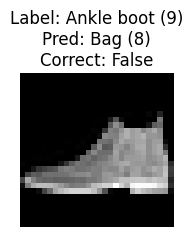

[해석 예시] 이 이미지는 원래 Ankle boot 인데 Bag 으로 분류됨.
- 이미지가 너무 어둡거나,
- 옷 형태가 비슷한 클래스(예: Shirt vs T-shirt/top),


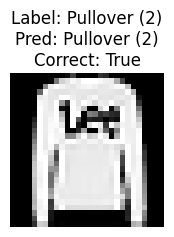

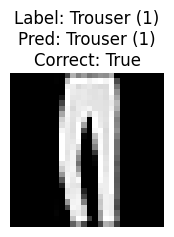

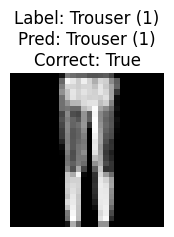

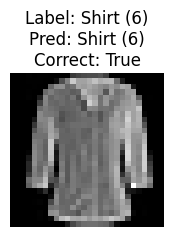

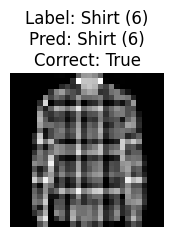

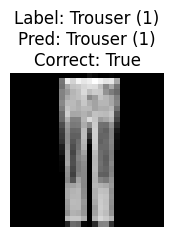

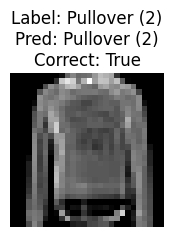

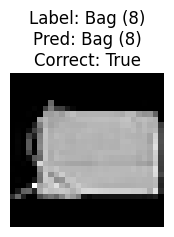

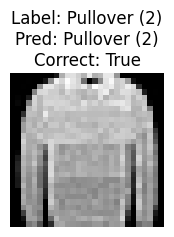

In [ ]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

latest_model = get_cnn_model2(config)#get_resnet_model(num_classes=10)
latest_file_path = os.path.join(CHECKPOINT_FILE_PATH, "cnn_mnist_with_normalization_checkpoint_latest.pt")
latest_model.load_state_dict(torch.load(latest_file_path, map_location=device))
latest_model = latest_model.to(device)

# 1) 모델 로드돼 있고 eval 모드라고 가정
latest_model.eval()

# 2) 테스트셋 전체를 한 번 돌면서 정답/오답 인덱스 모으기
all_images = []
all_labels = []
correct_idx = []
wrong_idx = []

with torch.no_grad():
    for i, (imgs, labels) in enumerate(test_data_loader):
        # 배치가 1보다 크면 쪼갤 거니까 그대로 CPU에 두자
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = latest_model(imgs)
        preds = outputs.argmax(dim=1)

        for b in range(imgs.size(0)):
            all_images.append(imgs[b].cpu())
            all_labels.append(labels[b].cpu())
            if preds[b].item() == labels[b].item():
                correct_idx.append(len(all_images) - 1)
            else:
                wrong_idx.append(len(all_images) - 1)

# 3) 이제 10개 고르기
selected_indices = []

# (1) 무조건 오답 하나 넣기
if len(wrong_idx) > 0:
    selected_indices.append(wrong_idx[0])  # 첫 번째 오답

# (2) 나머지는 맞은 것 위주로 채우기 (원하면 틀린 것도 더 추가 가능)
for idx in correct_idx[:9]:  # 이미 1개 넣었으니까 최대 9개만
    selected_indices.append(idx)
    if len(selected_indices) == 10:
        break

# 혹시 맞은 게 너무 적어서 10개가 안 됐다면 틀린 거에서 더 채우기
if len(selected_indices) < 10:
    for idx in wrong_idx[1:]:
        selected_indices.append(idx)
        if len(selected_indices) == 10:
            break

# 4) 출력하기
def show_fashion_mnist(img_tensor, title=""):
    # img_tensor: [1, 28, 28]
    img = img_tensor.squeeze(0)  # 28x28
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")

# 클래스 이름 있으면
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

for i, idx in enumerate(selected_indices):
    img = all_images[idx].unsqueeze(0).to(device)  # [1,1,28,28]
    label = all_labels[idx].item()

    with torch.no_grad():
        out = latest_model(img)
        pred = out.argmax(dim=1).item()

    plt.figure(figsize=(2,2))
    title = f"Label: {class_names[label]} ({label})\nPred: {class_names[pred]} ({pred})\nCorrect: {label == pred}"
    show_fashion_mnist(all_images[idx], title=title)
    plt.show()

    # 5) 오답 해석 예시
    if label != pred:
        print(f"[해석 예시] 이 이미지는 원래 {class_names[label]} 인데 {class_names[pred]} 으로 분류됨.")
        print("- 이미지가 너무 어둡거나,")
        print("- 옷 형태가 비슷한 클래스(예: Shirt vs T-shirt/top),")

torchinfo 모듈 사용한 모델 구조 출력 필요 (from torchinfoimport summary)

In [14]:
summary(
    latest_model,
    input_size=(1, 1, 28, 28),  # (batch_size, channels, height, width)
    col_names=("input_size", "output_size", "num_params", "kernel_size"),
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
CNN3_128                                 [1, 1, 28, 28]            [1, 10]                   --                        --
├─Sequential: 1-1                        [1, 1, 28, 28]            [1, 128, 7, 7]            --                        --
│    └─Conv2d: 2-1                       [1, 1, 28, 28]            [1, 32, 28, 28]           288                       [3, 3]
│    └─BatchNorm2d: 2-2                  [1, 32, 28, 28]           [1, 32, 28, 28]           64                        --
│    └─ReLU: 2-3                         [1, 32, 28, 28]           [1, 32, 28, 28]           --                        --
│    └─Conv2d: 2-4                       [1, 32, 28, 28]           [1, 64, 28, 28]           18,432                    [3, 3]
│    └─BatchNorm2d: 2-5                  [1, 64, 28, 28]           [1, 64, 28, 28]           128                       --
│    └

# 숙제후기
파이토치의 여러 기능들을 다시 한번 익히고 특히 CNN 계열의 모델들을 중점적으로 쓰는 기회를 가질 수 있게 되어 좋았다.

개인적으로 거대한 모델도 사용해보았지만 작은 모델의 성능이 훨씬 잘 나온 것에 대해서는 좀 의문이 들었다. 충분한 에포크가 있었다면 잘되었을까? 혹은 너무 과격하게 특징을 쳐내는 구조 때문에 잘 안된 것일까? 라는 추측이 들지만 정확한 것은 모르겠다.

드랍 아웃을 사용하지 못하여서 그런것인가 하는 생각이 든다. 큰 모델도 드랍아웃 없이는 충분한 성과를 못내는 것인가?

바둑에서 대마는 죽지 않는 것처럼 대모델은 승리하는 것으로 믿어왔는데 컴팩트한 모델에 진 것을 생각하니 이상하다.

하지만 목표치를 초과달성하였으므로 적당한 모델은 여러 기법 없이 충분히 좋은 성과를 낼 수 있다는 것을 알 수 있었다.

VIT를 한번 써보고싶었지만 목표를 달성해서 쓰지 않았다.

